In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
import warnings
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import precision_score,roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost
from sklearn.metrics import classification_report,f1_score,recall_score,confusion_matrix
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn import set_config

# Modelisation
## Importation des données

In [2]:
data = pd.read_csv('df1.csv')
data.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,367823,0,54000.0,334152.0,18256.5,270000.0,0.004960,-18496,-523,-3640.0,...,0,0,0,0,0,0,0,0,0,0
1,364348,0,211500.0,378117.0,30001.5,342000.0,0.002042,-20084,365243,-11313.0,...,0,0,0,0,1,0,0,1,0,0
2,405788,1,135000.0,152820.0,16177.5,135000.0,0.018029,-17747,-1824,-3264.0,...,0,0,0,0,0,1,0,1,0,0
3,389677,0,202500.0,707287.5,38497.5,562500.0,0.007274,-9937,-452,-2112.0,...,0,0,0,0,0,1,0,1,0,0
4,233092,0,135000.0,1292013.0,42700.5,1057500.0,0.035792,-21914,365243,-5265.0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
data = data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X = data.drop('TARGET', axis = 1)
y = data['TARGET'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## 1- DummyRegressor

In [4]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
set_config(display="diagram")  

model = DummyRegressor()
param_grid = {'strategy' : ['mean', 'median']}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ("std", StandardScaler()),  ("dum", DummyRegressor())], verbose = True)
pipe.fit(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold)
result = CV_gr.fit(X_train, y_train)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.4s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.2s
[Pipeline] ............... (step 3 of 3) Processing dum, total=   0.0s


In [5]:
result.best_score_

-2.579533469804218e-06

In [6]:
bestParam = result.best_params_
bestParam

{'strategy': 'mean'}

## 2- Regression Logistique

In [7]:
from sklearn.linear_model import LogisticRegression
X = data.drop('TARGET', axis = 1)
y = data['TARGET']


model = LogisticRegression(dual=False)
param_grid = { "penalty":["l2"], "C":[ 0.01, 0.1, 1, 10 ], "max_iter":[20000] }

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# les étapes du pipeline 
pipe = Pipeline([("sm", SMOTE()), ('std', StandardScaler()),  ("rgl", LogisticRegression())], verbose = False)
pipe.fit(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [8]:
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, refit=True, return_train_score=False)
result = CV_gr.fit(X_train, y_train)

In [9]:
result.best_score_

0.9172993016055873

In [10]:
bestParam = result.best_params_
bestParam 

{'C': 0.01, 'max_iter': 20000, 'penalty': 'l2'}

## 3- KNeighborsClassifier

In [11]:
from sklearn.neighbors import KNeighborsClassifier

X = data.drop('TARGET', axis = 1)
y = data['TARGET']

model = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1,35),
             'weights': ['uniform', 'distance']} 
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ('std', StandardScaler()),  ("knb", KNeighborsClassifier())], verbose = True)
pipe.fit(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.4s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing knb, total=   0.0s


In [12]:
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, refit=True, return_train_score=False)
result = CV_gr.fit(X_train, y_train)

In [13]:
result.best_score_

0.9131175750593996

In [14]:
bestParam = result.best_params_
bestParam

{'n_neighbors': 10, 'weights': 'uniform'}

 ## 4- Forêt aléatoire

In [15]:
from sklearn.ensemble import RandomForestClassifier
X = data.drop('TARGET', axis = 1)
y = data['TARGET']

model = RandomForestClassifier(random_state=42)
param_grid = {'n_estimators' :[200, 500], 'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ("std", StandardScaler()),  ("clas", RandomForestClassifier())], verbose = True)
pipe.fit(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.4s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] .............. (step 3 of 3) Processing clas, total=   6.0s


In [16]:
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, refit=True, cv=kfold, verbose=1)
result = CV_gr.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [17]:
result.best_score_

0.9170280950768832

In [18]:
bestParam = result.best_params_
bestParam

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

## 5- Support  Vecteurs Machines (SVM)

In [19]:
data = pd.read_csv('dat_svm.csv')
data = data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X = data.drop('TARGET', axis = 1)
y = data['TARGET'] 

In [20]:
from sklearn.svm import SVC

model = SVC()
param_grid = {'C': [0.1],  
              'gamma': [0.01 ], 
              'kernel': ['linear','rbf']}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ("std", StandardScaler()),  ("svm", SVC())], verbose = True)
pipe.fit(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.1s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing svm, total=   0.1s


In [21]:
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, cv=kfold, verbose=1)
result = CV_gr.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [22]:
result.best_score_

0.9301204819277109

In [23]:
bestParam = result.best_params_
bestParam

{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

## 6- XGBoots Classifier

In [24]:
data = pd.read_csv('df1.csv')
data = data.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [25]:
from xgboost import XGBClassifier
X = data.drop('TARGET', axis = 1)
y = data['TARGET']

model = XGBClassifier()
param_grid = {'nthread':[2], 'objective':['binary:logistic'],'n_estimators': [ 800],
              'learning_rate': [0.01, 0.02], 'gamma': [2 ], 'max_depth': [ 4] }
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# les étapes du pipeline :
pipe = Pipeline([("sm", SMOTE()), ("std", StandardScaler()),  ("xgb", XGBClassifier())], verbose = True)
pipe.fit(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

[Pipeline] ................ (step 1 of 3) Processing sm, total=   0.3s
[Pipeline] ............... (step 2 of 3) Processing std, total=   0.1s
[Pipeline] ............... (step 3 of 3) Processing xgb, total=  16.9s


In [26]:
CV_gr = GridSearchCV(model, param_grid, n_jobs=-1, refit=True, cv=kfold,  verbose=1)
result = CV_gr.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [27]:
result.best_score_

0.9160162209154097

In [28]:
bestParam = result.best_params_
bestParam 

{'gamma': 2,
 'learning_rate': 0.01,
 'max_depth': 4,
 'n_estimators': 800,
 'nthread': 2,
 'objective': 'binary:logistic'}

In [24]:
def modelis(data=[], verbose=False):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    # Appliquer le rééchantillonnage SMOTE sur les données
    X_sm, y_sm = smote.fit_resample(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.2)
    #Liste des modèles à entrainer
    models=[LogisticRegression(C = 0.01, max_iter = 20000, penalty = 'l2', dual=False),
            KNeighborsClassifier(n_neighbors = 8, weights ='uniform'),
            SVC(C= 0.1, gamma = 0.01, kernel ='rbf', probability=True),
            RandomForestClassifier(criterion = 'gini', max_depth=4, n_estimators=200, random_state=42, oob_score=True),
            XGBClassifier(gamma= 2,learning_rate = 0.01, max_depth = 4, n_estimators = 800, nthread = 2,
                          objective= 'binary:logistic')]
    f1_sc = []
    auc_sc = []
    recall_sc = []
    preci_sc = []
    #Entrainement des modèles pour obtenir leurs mesures de performances
    for model in models:
        clf = model
        clf.fit(X_train, y_train)
        test_preds = clf.predict(X_test)
        f1_sc.append(f1_score(y_test, test_preds))
        auc_sc.append(roc_auc_score(y_test, test_preds))
        recall_sc.append(recall_score(y_test, test_preds))
        preci_sc.append(precision_score(y_test, test_preds))
        #Impression de modèle et du rapport
        if verbose:
            print('Classification Model: ',model,'\n')
            print(classification_report(y_test, test_preds),'\n')
            y_pred_proba = clf.predict_proba(X_test)[::, 1]
            tauc = metrics.roc_auc_score (y_test, y_pred_proba).round(2)
            print('Le Score AUC est: ',tauc,'\n')
    #Enregistrer les resultats dans un dataframe
    results = pd.DataFrame([f1_sc,auc_sc, preci_sc,recall_sc],
                      index= ['f1_score','roc_auc','precision','recall',],
                           columns=['LogisticRegression','KNeighborsClassifier','SVC','RandomForestClassifier','XGBClassifier'])
    return results.transpose()

## Comparaison  des scores des differents modèles : Precison, recall, f1-score et l'AUC 

In [25]:
compar = modelis(data=[X_test,y_test], verbose=True)

Classification Model:  LogisticRegression(C=0.01, max_iter=20000) 

              precision    recall  f1-score   support

           0       0.60      0.61      0.60      1740
           1       0.58      0.56      0.57      1642

    accuracy                           0.59      3382
   macro avg       0.59      0.59      0.59      3382
weighted avg       0.59      0.59      0.59      3382
 

Le Score AUC est:  0.61 

Classification Model:  KNeighborsClassifier(n_neighbors=8) 

              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1740
           1       0.74      0.91      0.82      1642

    accuracy                           0.80      3382
   macro avg       0.82      0.81      0.80      3382
weighted avg       0.82      0.80      0.80      3382
 

Le Score AUC est:  0.89 

Classification Model:  SVC(C=0.1, gamma=0.01, probability=True) 

              precision    recall  f1-score   support

           0       0.00      0.00      0

## Le meilleur modèle par metric

In [26]:
print('Les Meilleurs modèles en fonction du metrique sont : ','\n')
for metric in compar.columns:
    print(f'{metric.capitalize()}:',compar.sort_values(metric,ascending=False).index[0])

Les Meilleurs modèles en fonction du metrique sont :  

F1_score: XGBClassifier
Roc_auc: XGBClassifier
Precision: XGBClassifier
Recall: SVC


In [28]:
b_mdl=XGBClassifier(gamma= 2,learning_rate = 0.01, max_depth = 4, n_estimators = 800, nthread = 2,objective= 'binary:logistic')
b_mdl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, nthread=2, num_parallel_tree=None,
              predictor=None, ...)

In [29]:
y_pred_sm = b_mdl.predict(X_test)
b_mdl.score(X_test, y_test)

0.9176151761517615

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_sm)

array([[1691,    1],
       [ 151,    2]], dtype=int64)

## Calcul de fbeta_score

In [31]:
from sklearn.metrics import fbeta_score, make_scorer
mon_score = fbeta_score(y_test, y_pred_sm, beta=2)
mon_score

0.016260162601626015

## Evaluation des métriques par validation croisée avec les temps d'entrainement et les scores avec cross_validate

In [32]:
m_score =dict(beta=make_scorer(fbeta_score, beta=2))

In [33]:
from sklearn.model_selection import cross_validate
model_cros = XGBClassifier(gamma = 2, learning_rate=0.02, max_depth= 4, n_estimators=800, objective='binary:logistic', nthread=2)
eva_mdl = cross_validate(model_cros, X_train, y_train, cv=5, scoring=m_score, return_train_score=True,return_estimator=True)

In [34]:
print(eva_mdl['fit_time'])

[35.51776457 45.29934669 36.6240139  47.11616802 62.56739116]


In [35]:
print(eva_mdl['score_time'])

[0.04868436 0.08592629 0.11282778 0.03700662 0.03125477]


## La courbe ROC Curve

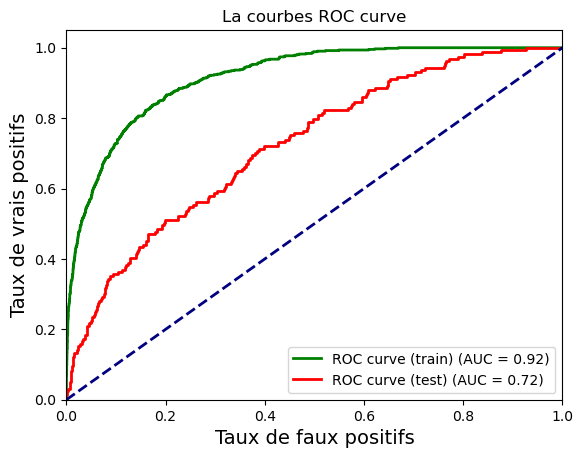

In [54]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
y_train_pred = b_mdl.predict_proba(X_train)[:, 1]
y_pred_proba = b_mdl.predict_proba(X_test)[:, 1]

[fpr_in, tpr_in, thr] = metrics.roc_curve(y_train, y_train_pred)
roc_auc_tr = auc(fpr_in, tpr_in)
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
roc_auc_test = auc(fpr, tpr)

plt.plot(fpr_in, tpr_in, color='green', lw=2, label='ROC curve (train) (AUC = %0.2f)' % roc_auc_tr)
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (test) (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs', fontsize=14)
plt.ylabel('Taux de vrais positifs', fontsize=14)
plt.title('La courbes ROC curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
import shap
explainer = shap.Explainer(b_mdl, X)
shap_values = explainer(X_test)

 98%|===================| 1816/1845 [00:35<00:00]        

### Les features les plus importants en moyenne 
La méthode SHAP permet de mesurer l’impact sur la prédiction d’ajouter une variable grâce à des permutations de toutes les options possibles. Elle teste sur chaque combinaison possible des autres variables la différence des prédictions entre une variable pointée et une autre. c'est un travail fastigieux !

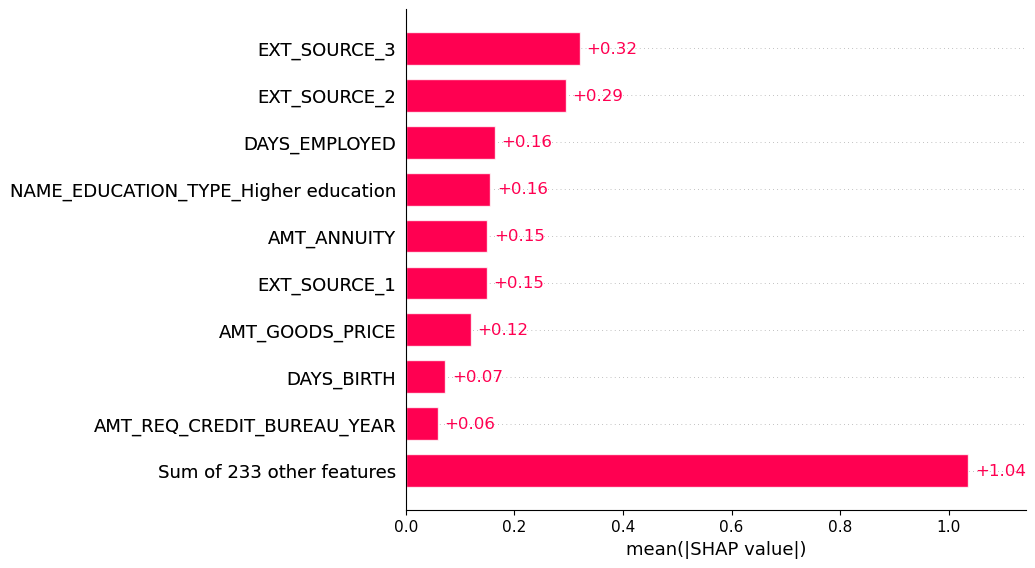

In [37]:
shap.plots.bar(shap_values)

### Explicabilité
Il est également possible d’expliquer quels ont été les features moteurs pour amener à la prédiction finale pour un individu en particulier. Il s’agit donc d’une explication locale et non globale. La couleur des points correspond à la valeur de la variable et le positionnement horizontal des points correspond à la SHAPley valeur.

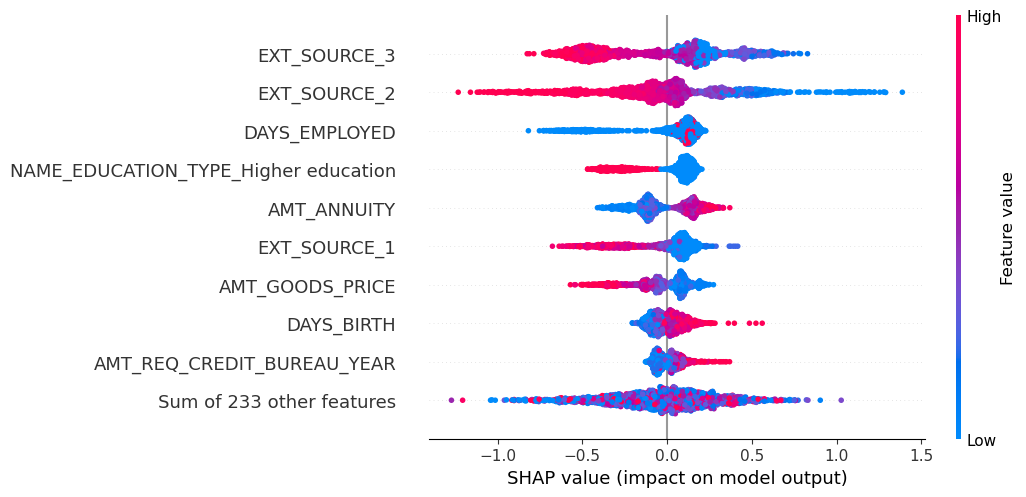

In [38]:
shap.plots.beeswarm(shap_values)

## Conclusion

Durant ce projet j’ai eu à utiliser plusieurs models, avec chacun ses caracteristiques, celui qui m’a le plus marqué est xgboot avec sa rapidité, sa performance sa capacité à optimiser les ressources utilisées. Elle est très efficace avec les jeux de données volumineux.
